In [ ]:
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TEST_DIR = '/content/drive/MyDrive/dataset'
MODEL_PATH = '/content/drive/MyDrive/LRModel/model.pth'

BATCH_SIZE = 60
SCALE = 0.25
N_FRAMES = None # 'None' means using all available frames
DEFAULT_PROB = 0.5

In [ ]:
# Install facenet-pytorch
!pip install facenet-pytorch

from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.5 MB/s eta 0:00:00


In [ ]:
import os
import glob
import json
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

if torch.cuda.is_available():
    device = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [ ]:
# Source: https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces
    

class LogisticRegression(nn.Module):
    def __init__(self, D_in=1, D_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(D_in, D_out)
        
    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = torch.sigmoid(y_pred)
        
        return y_pred

In [ ]:
# Source: https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
def process_faces(faces, feature_extractor):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    if len(faces) == 0:
        return None
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = feature_extractor(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

In [ ]:
# Load model.
classifier = LogisticRegression()
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.eval()

LogisticRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
# Get all test videos.
all_test_videos = glob.glob(os.path.join(TEST_DIR, '*.mp4'))

In [ ]:
# Load face detector.
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model.
feature_extractor = InceptionResnetV1(pretrained='vggface2', device=device).eval()

# Define face detection pipeline.
detection_pipeline = DetectionPipeline(detector=face_detector, n_frames=N_FRAMES, batch_size=BATCH_SIZE, resize=SCALE)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
X_test = []

with torch.no_grad():
    for path in tqdm(all_test_videos):
        try:
            # Detect all faces occur in the video.
            faces = detection_pipeline(path)

            # Calculate the distances of all faces' feature vectors to the centroid.
            distances = process_faces(faces, feature_extractor)
            X_test.append(distances)
        except:
            X_test.append(None)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

In [ ]:
submission = []

with torch.no_grad():
    for path, distances in zip(all_test_videos, X_test):
        file_name = os.path.basename(path)

        if distances is not None:
            distances = torch.tensor(distances).unsqueeze(dim=1).float().to(device)
            y_pred = classifier(distances)
            y_pred = float(y_pred.mean().cpu().numpy())
        else:
            y_pred = DEFAULT_PROB

        submission.append([file_name, y_pred])

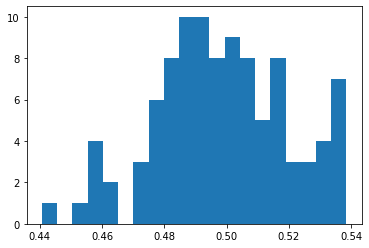

In [ ]:
submission = pd.DataFrame(submission, columns=['filename', 'label'])
submission.sort_values('filename').to_csv('submission.csv', index=False)

plt.hist(submission.label, 20)
plt.show()